For identifying the aspects in the review text we will be using the Latent Dirichlet Allocation

Assumptions - LDA assumes that each document is a mixture of small number of topics and each topic is a mixture of words, where the words could contribute to multiple topics but with different probabilities

The algorithm goes through each doc and assigns every word to a temporary topic then it looks at how prevalent each word is across topics. 

This is done iteratively until the assignments reach a steady state

Each topic is characterized by a distribution of words and after running LDA you get a list of topics 

Therefore the crucial decision in LDA is the selection of the number of topics 

In [1]:
#Lets use gensim to perform LDA topic modeling 
!pip install gensim
from gensim import corpora, models 
import gensim

In [2]:
import pandas as pd

df = pd.read_json('final_dataset.json')

In [7]:
#Create a subset with 10k reviews to catch the nuances of the aspects in the data
#Create a sample dataset
subset_size = 10000
subset_dataset = df.sample(n=subset_size, random_state=42)

In [12]:
import ast

# A safer approach to convert strings to lists when possible
def safe_literal_eval(s):
    try:
        # Only try to evaluate strings that start with '[' and end with ']'
        if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
            return ast.literal_eval(s)
        return s  # Return the original value if not a string representation of a list
    except (ValueError, SyntaxError):
        # Return the original string if there's an error in conversion
        return s

# Apply this function to your column
subset_dataset['clean_reviewText'] = subset_dataset['clean_reviewText'].apply(safe_literal_eval)


In [14]:
# Validate and convert data to ensure it's in the correct format
def ensure_list_of_tokens(text):
    if isinstance(text, str):  # If the text is a string
        # Attempt to convert from string to list; this depends on your data's format
        # For example, if your strings are space-separated tokens:
        return text.split()
    elif isinstance(text, list):
        return text  # It's already a list, return as-is
    else:
        return []  # In case of unexpected data types

# Apply this function to each item in the column
subset_dataset['clean_reviewText'] = subset_dataset['clean_reviewText'].apply(ensure_list_of_tokens)


Creating the dictionary and corpus for LDA

In [15]:
# This step converts your list of words into a bag-of-words format
dictionary = corpora.Dictionary(subset_dataset['clean_reviewText'])

In [16]:
#Filter out the extremes to remove the noise
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [17]:
# Convert dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in subset_dataset['clean_reviewText']]

Running the LDA Topic modeling 

In [18]:
from gensim.models.ldamodel import LdaModel

In [19]:
#Lets set the training parameters
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None #Don't evaluate model perplexity, takes too much time.

In [20]:
#Make the index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

In [22]:
from gensim.models import LdaMulticore

#Train the LDA model 
model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    chunksize=chunksize,
    passes=passes,
    iterations=iterations,
    workers=8  # Adjust this to the number of available CPU cores - 1
)

The results below show the top words for each topic generated by the LDA model. The next step is to interpret these topics adn assign them meaningful labels based on the topic words and then use them to classify the reviews according to the topics and it will help in identifying the aspects in the dataset.

In [23]:
#Print the keywords in the 10 topics 
for idx, topic in model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.030*"work" + 0.023*"filter" + 0.016*"great" + 0.012*"well" + 0.012*"one" + 0.011*"easy" + 0.010*"fit" + 0.010*"love" + 0.010*"get" + 0.010*"price"
Topic: 1 
Words: 0.015*"knife" + 0.011*"oil" + 0.011*"one" + 0.009*"like" + 0.009*"use" + 0.009*"would" + 0.009*"product" + 0.008*"blade" + 0.007*"good" + 0.007*"used"
Topic: 2 
Words: 0.016*"fit" + 0.014*"like" + 0.014*"size" + 0.011*"would" + 0.010*"love" + 0.009*"well" + 0.009*"small" + 0.009*"color" + 0.009*"one" + 0.009*"really"
Topic: 3 
Words: 0.039*"great" + 0.025*"product" + 0.014*"price" + 0.013*"love" + 0.012*"good" + 0.012*"taste" + 0.011*"use" + 0.009*"flavor" + 0.009*"one" + 0.008*"make"
Topic: 4 
Words: 0.011*"one" + 0.007*"wire" + 0.007*"use" + 0.007*"set" + 0.007*"door" + 0.006*"need" + 0.006*"nice" + 0.006*"would" + 0.005*"work" + 0.005*"well"
Topic: 5 
Words: 0.028*"movie" + 0.025*"good" + 0.019*"like" + 0.012*"really" + 0.010*"one" + 0.010*"great" + 0.009*"dont" + 0.009*"would" + 0.008*"version" + 0.006

Topic 0 has top words like "work", "filter", "easy", it might be related to usability or functionality of a product.
 Topic 1 has words like "knife", "blade", "used", it might represent discussions about kitchen tools.

In [24]:
#Now we wil assign the topics to the documents in the corpus
dominant_topics = []
for i, row_list in enumerate(model[corpus]):
    row = row_list[0] if model.per_word_topics else row_list            
    # Sort with the most dominant topic first   
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            dominant_topics.append((i, topic_num, round(prop_topic,4), topic_keywords))
        else:
            break

In [25]:
# Add the dominant topic numbers to the original dataframe
subset_dataset['dominant_topic'] = [topic_num for _, topic_num, _, _ in dominant_topics]

Now lets review the topic assignments

In [26]:
# Show some of the documents and their assigned dominant topics
for document, topic_number in zip(subset_dataset['clean_reviewText'].head(10), subset_dataset['dominant_topic'].head(10)):
    print("Document: ", document)
    print("Assigned Topic: ", topic_number, "\n")

Document:  ['make', 'getting', 'large', 'roast', 'pan', 'easy', 'dont', 'forget', 'unlike', 'picture', 'put', 'oven', 'mitt', 'since', 'frame', 'get', 'hot', 'sorry', 'didnt', 'year', 'ago']
Assigned Topic:  7 

Document:  ['great', 'price', 'work', 'great']
Assigned Topic:  3 

Document:  ['curious', 'durable', 'would', 'ordering', '2', 'chopped', 'coconut', 'live', 'wood', 'one', 'neither', 'blade', 'took', 'damage', 'nice', 'knife', 'price']
Assigned Topic:  0 

Document:  ['price', 'one', 'best', 'hat', 'buy', 'plan', 'buying', 'another', 'couple', 'week']
Assigned Topic:  3 

Document:  ['fit', 'great', 'thin', 'soft']
Assigned Topic:  2 

Document:  ['chopper', 'good', 'many', 'thing', 'everything', 'work', 'well', 'stiff', 'vegetable', 'like', 'onion', 'crush', 'softer', 'thing']
Assigned Topic:  2 

Document:  ['excelente']
Assigned Topic:  0 

Document:  ['got', 'unit', 'hccost', 'one', 'stove', 'work', 'thermal', 'couple', 'mounted', 'well', 'gas', 'would', 'come', 'however',

In [27]:
subset_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1353734 to 1171231
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   overall                  10000 non-null  int64 
 1   vote                     10000 non-null  int64 
 2   verified                 10000 non-null  bool  
 3   reviewerID               10000 non-null  object
 4   asin                     10000 non-null  object
 5   style                    10000 non-null  object
 6   reviewerName             10000 non-null  object
 7   reviewText               10000 non-null  object
 8   summary                  10000 non-null  object
 9   has_image                10000 non-null  int64 
 10  clean_reviewText         10000 non-null  object
 11  clean_summary            10000 non-null  object
 12  reviewText_length        10000 non-null  int64 
 13  clean_reviewText_length  10000 non-null  int64 
 14  review_emotions          10000 non-

In [28]:
#So as we have 10 topics we will label them to one topic and then analyze them'
topic_labels = {0: 'Work Efficiency', 1: 'Kitchen Tools', 2: 'Fitness and Apparel', 3: 'Food and Beverage Quality', 4: 'Home and Safety', 5: 'Entertainment and Electronics', 6: 'Mobile and Accessories', 7: 'Water and Beverages', 8: 'Lighting and Energy', 9: 'Media and Content'}

In [29]:
# Map the dominant topic numbers to their labels
subset_dataset['topic_label'] = subset_dataset['dominant_topic'].map(topic_labels)


In [30]:
# Analyze the distribution of topics
topic_distribution = subset_dataset['topic_label'].value_counts()
print(topic_distribution)

topic_label
Fitness and Apparel              1753
Food and Beverage Quality        1455
Work Efficiency                  1313
Water and Beverages              1226
Mobile and Accessories            873
Media and Content                 863
Lighting and Energy               824
Entertainment and Electronics     601
Kitchen Tools                     576
Home and Safety                   516
Name: count, dtype: int64


In [31]:
#Detailed Topic review
selected_topic = 0
sample_reviews = subset_dataset[subset_dataset['dominant_topic'] == selected_topic]['clean_reviewText'].sample(10)

In [32]:
for review in sample_reviews:
    print(review)
    print('\n')

['work', 'advertised']


['great', 'tool', 'great', 'price', 'get', 'job', 'done']


['luv']


['hose', 'work', 'doesnt', 'seem', 'kink', 'much', 'hose', 'price', 'right', 'delivery', 'quick']


['easy', 'install', 'good', 'quality']


['lookes', 'like', 'old', 'one', 'hold', 'water', 'doctor', 'ordered', 'thanks', 'survey', 'demanding']


['finally', 'looking', 'cheaper', 'alternative', 'frige', 'filter', 'work', 'perfectly', 'water', 'quality', 'compare', 'oem', 'careful', 'pick', 'model', 'look', 'identical', 'look', 'closely', 'neck', 'filter', 'compare', 'one', 'using', 'way', 'teeth', 'look', 'critical', 'nearly', 'fit']


['arrived', 'quickly', 'good', 'condition', 'assembled', 'easily', 'work', 'well', 'happy', 'product', 'would', 'recommend']


['item', 'described', 'arrived', 'time']


['ordered', 'battery', 'terminal', 'number', 'time', 'building', 'road', 'vehicle', 'work', 'great']




In [36]:
#Detailed Topic review
selected_topic = 5
sample_reviews = subset_dataset[subset_dataset['dominant_topic'] == selected_topic]['clean_reviewText'].sample(10)

for review in sample_reviews:
    print(review)
    print('\n')

['video', 'sound', 'quality', 'great', 'plus', 'show', 'enjoy', 'much', 'many', 'year', 'ago', 'im', 'appreciative', 'made', 'available', 'subtitle', 'dvd', 'sold', 'year', '2012', 'without', 'english', 'spanish', 'subtitle', 'show', 'dont', 'age', 'well', 'welcome', 'back', 'kotter', 'seemed', 'cool', 'kid', 'home', 'improvement', 'watch', 'seem', 'corny', 'could', 'liked', 'show', 'like', 'courtship', 'eddy', 'father', 'hogan', 'hero', 'mchales', 'navy', 'ageless', 'china', 'beach', 'become', 'available', 'dvd', 'amazon', 'orginal', 'music']


['look', 'understand', 'bigname', 'film', 'there', 'going', 'multiple', 'home', 'version', 'given', 'format', 'usually', 'there', 'basic', 'version', 'includes', 'film', 'maybe', 'one', 'two', 'feature', 'like', 'commentary', 'deleted', 'scene', 'something', 'otherwise', 'pretty', 'minimal', 'stuff', 'thats', 'fine', 'considering', 'often', 'charge', '2030', 'kind', 'version', 'usually', 'release', 'real', 'special', 'featuresheavy', 'version',

Combine with sentiment analysis

In [33]:
!pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 163.8 kB/s eta 0:00:04
   - ------------------------------------- 30.7/626.3 kB 163.8 kB/s eta 0:00:04
   - ------------------------------------- 30.7/626.3 kB 163.8 kB/s eta 0:00:04
   --- ----------------------------------- 61.4/626.3 kB 192.5 kB/s eta 0:00:03
   --- ----------------------------------- 61.4/626.3 kB 192.5 kB/s eta 0:00:03
   --- ----------------------------------- 61.4/626.3 kB 192.5 kB/s eta 0:00:03
   ------- ------------------------------ 122.9/626.3 kB 266.9 kB/s eta 0:00:02
   ------- -

In [34]:
from textblob import TextBlob

# Function to get the sentiment
def get_sentiment(text):
    # Converting list of tokens back to string
    text_str = ' '.join(text)
    # Calculating sentiment
    return TextBlob(text_str).sentiment.polarity

In [35]:
#Applying the function to the reviews
subset_dataset['sentiment'] = subset_dataset['clean_reviewText'].apply(get_sentiment)

#Analyze the average sentiment for each topic
average_sentiment_per_topic = subset_dataset.groupby('dominant_topic')['sentiment'].mean()
print(average_sentiment_per_topic)

dominant_topic
0    0.337079
1    0.202112
2    0.266347
3    0.436340
4    0.198644
5    0.295995
6    0.375117
7    0.156519
8    0.222361
9    0.168992
Name: sentiment, dtype: float64


 Visualize the Distribution of Topics

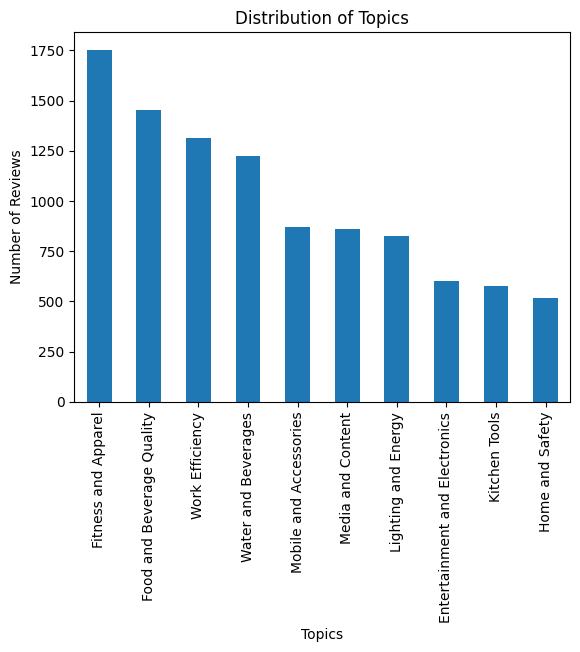

In [37]:
import matplotlib.pyplot as plt

# 'topic_label' is a column with human-readable labels for each topic
topic_distribution = subset_dataset['topic_label'].value_counts()

topic_distribution.plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Number of Reviews')
plt.show()

Cross-Analysis with Other Features

In [39]:
average_rating_per_topic = subset_dataset.groupby('dominant_topic')['overall'].mean()
print(average_rating_per_topic)

dominant_topic
0    4.282559
1    3.901042
2    4.035368
3    4.624055
4    4.184109
5    3.925125
6    4.286369
7    3.825449
8    4.060680
9    3.879490
Name: overall, dtype: float64


In [40]:
subset_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1353734 to 1171231
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall                  10000 non-null  int64  
 1   vote                     10000 non-null  int64  
 2   verified                 10000 non-null  bool   
 3   reviewerID               10000 non-null  object 
 4   asin                     10000 non-null  object 
 5   style                    10000 non-null  object 
 6   reviewerName             10000 non-null  object 
 7   reviewText               10000 non-null  object 
 8   summary                  10000 non-null  object 
 9   has_image                10000 non-null  int64  
 10  clean_reviewText         10000 non-null  object 
 11  clean_summary            10000 non-null  object 
 12  reviewText_length        10000 non-null  int64  
 13  clean_reviewText_length  10000 non-null  int64  
 14  review_emotions    

In [41]:
subset_dataset.head(10)

overall  vote  verified      reviewerID        asin  \
1353734        5     4      True   AI9P883IL85RF  B004E5QJQ6   
120217         5     0      True  A1ED7YP0AZ5MTS  B000HE6ECM   
1730710        5     9      True  A179UKCSK3WE50  B01EYCEBMC   
1687571        5     0      True   AMAWMMWM7IVTL  B00EQSL3LC   
751410         5     0      True  A3AP2MA7YIWA4F  B00T42620M   
1253496        4     3      True   AHOA85GY3G7Q7  B0095PC6UI   
1780574        5     0      True  A22Q9MIG98QU0T  B00QBW8Z08   
169438         5     3     False   AMHL204PVY3I2  B00BUQMUSS   
917318         5     0      True  A2Z1NF15JREEXX  B00FXW7ZZS   
714296         5     0      True   ASZNLOLLIRTN8  B00QN1T6NM   

                                                     style       reviewerName  \
1353734                               {'Color:': ' Black'}           Jay Burn   
120217                                             Unknown           Reader 1   
1730710                                            Unknown      Drea Jeffries   
1687571  {'Size:': ' Large/X-Large', 'Team Name:': ' Bo...    Amazon Customer   
751410                                             Unknown  Rick In NorthEast   
1253496                          {'Style Name:': ' Black'}             Trisha   
1780574                                            Unknown             aidoly   
169438                                             Unknown       Tony T. Wong   
917318   {'Color:': ' Platinum-Plated', 'Metal Type:': ...   Robin M. Scolini   
714296                                             Unknown    Amazon Customer   

                                                reviewText  \
1353734  This makes getting a large roast out of the pa...   
120217                          Great price. Works great!!   
1730710  I was curious about how durable it would be, a...   
1687571  For the price this is one of the best hats tha...   
751410                          Fits great, thin and soft.   
1253496  This chopper is good for many things, but not ...   
1780574                                          Excelente   
169438   I got this unit from HCcost.  One of the stove...   
917318                                        I love it!!!   
714296   This was my first glass protector purchased fr...   

                                                   summary  has_image  ...  \
1353734         Don't roast a 20 pound "beast" without it.          0  ...   
120217                                          Five Stars          0  ...   
1730710                      more than just a pretty blade          0  ...   
1687571                                   Very comfortable          0  ...   
751410                                           Good buy.          0  ...   
1253496           Good for many things, but not everything          0  ...   
1780574                                         Five Stars          0  ...   
169438   However the customer support of HCcost was ama...          0  ...   
917318                                          Five Stars          0  ...   
714296                                            Iphone 6          0  ...   

                                             clean_summary reviewText_length  \
1353734                  dont roast 20 pound beast without                38   
120217                                           five star                 4   
1730710                                       pretty blade                37   
1687571                                        comfortable                23   
751410                                            good buy                 5   
1253496                         good many thing everything                26   
1780574                                          five star                 1   
169438   however customer support hccost amazing fixed ...                52   
917318                                           five star                 3   
714296                                            iphone 6            

Now lets extract the aspects from the review text

Dependency parsing and noun phrase extraction

In [48]:
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.0/12.8 MB 281.8 kB/s eta 0:00:46
     --------------------------------------- 0.1/12.8 MB 459.5 kB/s eta 0:00:28
     --------------------------------------- 0.1/12.8 MB 514.3 kB/s eta 0:00:25
      -------------------------------------- 0.2/12.8 MB 655.4 kB/s eta 0:00:20
      -------------------------------------- 0.2/12.8 MB 752.5 kB/s eta 0:00:17
      -------------------------------------- 0.3/12.8 MB 770.1 kB/s eta 0:00:17
     - ------------------------------------- 0.3/12.8 MB 807.1 kB/s eta 0:00:16


In [49]:
# Function to extract noun phrases
def extract_aspects(text_list):
    aspects = []
    for doc in nlp.pipe([' '.join(text) for text in text_list], disable=["ner", "textcat"]):  # 'text' should be a string of words
        for chunk in doc.noun_chunks:
            aspects.append(chunk.text)
    return aspects

In [50]:
# Apply the function to your dataset
subset_dataset['aspects'] = subset_dataset['clean_reviewText'].apply(extract_aspects)

Frequency Aspect Extraction - identify the most frequently mentioned aspects across the reviews

In [51]:
from collections import Counter

# Flatten the list of all aspects
all_aspects = [aspect for sublist in subset_dataset['aspects'] for aspect in sublist]

# Count the occurrences of each aspect
aspect_counts = Counter(all_aspects)

# Print the most common aspects
print(aspect_counts.most_common(20))

[('i', 100296), ('e', 63539), ('g', 25423), ('t', 19524), ('s', 17682), ('u', 14017), ('o', 13680), ('m', 11725), ('d', 10923), ('c', 10012), ('p', 8123), ('r', 7790), ('h', 6837), ('w', 6406), ('a l', 5668), ('l', 5615), ('r e', 5482), ('k', 5270), ('f', 5022), ('y', 4563)]


Aspect Filtering and Refinement

Not all extracted noun phrases are useful aspects. Filter out irrelevant ones based on frequency thresholds or manual review.

In [52]:
# Set a minimum frequency threshold for aspects to be considered significant
min_freq = 5

# Filter out aspects below the threshold
significant_aspects = {aspect: count for aspect, count in aspect_counts.items() if count >= min_freq}

print(significant_aspects)

{'a k': 1808, 'e': 63539, 'g e t t': 345, 'i': 100296, 'g': 25423, 'l a r g e': 376, 'r o': 434, 'p': 8123, 'e a s y': 964, 'f o r g e t': 69, 'u': 14017, 'l': 5615, 'k': 5270, 't': 19524, 'r': 7790, 'p u t': 828, 'o': 13680, 'f r': 202, 'g e t': 2031, 'h o t': 258, 'o r r y': 43, 'a g o': 201, 'g r e': 2978, 'p r': 1403, 'w o r k': 1947, 'c u r i o u s': 20, 'r d e r i': 82, 'c h': 3396, 'p e d': 11, 'c o c o n u t': 43, 'w': 6406, 'd': 10923, 'h e': 1066, 'b l a d e': 261, 'a g': 940, 'k n i f e': 357, 'a t': 3359, 'p l': 2678, 'b u y i': 235, 'a n o t h e r': 623, 'c o u p l e': 316, 'f i': 1990, 't h i': 2671, 'o f t': 223, 'o p p e r': 23, 'y': 4563, 'h': 6837, 'w e l l': 2023, 'e g e t a b l': 32, 'l i k e': 2985, 'c r u s h': 12, 'o f t e r': 20, 'e x c e l e n t e': 5, 'g o t': 757, 's t': 819, 't o': 1917, 't h e r m': 22, 'm o u n t e d': 67, 'a s': 391, 'w e': 1647, 'c u s t o m e r': 150, 'u p p o r t': 153, 'a z': 268, 'g h t': 1262, 'a w': 787, 'a y': 3541, 'w o r k i': 2

Map the reviews to aspects 

In [53]:
# Function to map reviews to significant aspects
def map_review_to_aspects(review_aspects, significant_aspects):
    return [aspect for aspect in review_aspects if aspect in significant_aspects]

In [54]:
subset_dataset.head()

overall  vote  verified      reviewerID        asin  \
1353734        5     4      True   AI9P883IL85RF  B004E5QJQ6   
120217         5     0      True  A1ED7YP0AZ5MTS  B000HE6ECM   
1730710        5     9      True  A179UKCSK3WE50  B01EYCEBMC   
1687571        5     0      True   AMAWMMWM7IVTL  B00EQSL3LC   
751410         5     0      True  A3AP2MA7YIWA4F  B00T42620M   

                                                     style       reviewerName  \
1353734                               {'Color:': ' Black'}           Jay Burn   
120217                                             Unknown           Reader 1   
1730710                                            Unknown      Drea Jeffries   
1687571  {'Size:': ' Large/X-Large', 'Team Name:': ' Bo...    Amazon Customer   
751410                                             Unknown  Rick In NorthEast   

                                                reviewText  \
1353734  This makes getting a large roast out of the pa...   
120217                          Great price. Works great!!   
1730710  I was curious about how durable it would be, a...   
1687571  For the price this is one of the best hats tha...   
751410                          Fits great, thin and soft.   

                                            summary  has_image  ...  \
1353734  Don't roast a 20 pound "beast" without it.          0  ...   
120217                                   Five Stars          0  ...   
1730710               more than just a pretty blade          0  ...   
1687571                            Very comfortable          0  ...   
751410                                    Good buy.          0  ...   

        reviewText_length clean_reviewText_length  \
1353734                38                      21   
120217                  4                       4   
1730710                37                      17   
1687571                23                      10   
751410                  5                       4   

                                           review_emotions  \
1353734  [amusement, pride, surprise, disapproval, real...   
120217   [disappointment, disapproval, pride, confusion...   
1730710  [approval, pride, gratitude, disappointment, n...   
1687571  [pride, disapproval, excitement, neutral, disg...   
751410   [disappointment, disapproval, pride, confusion...   

                       review_emotion_scores dominant_emotion  \
1353734  [0.719, 0.131, 0.047, 0.019, 0.019]        amusement   
120217   [0.994, 0.002, 0.001, 0.000, 0.000]   disappointment   
1730710  [0.881, 0.033, 0.026, 0.019, 0.013]         approval   
1687571  [0.995, 0.002, 0.001, 0.000, 0.000]            pride   
751410   [0.991, 0.003, 0.002, 0.001, 0.000]   disappointment   

                        inferred_intent dominant_topic  \
1353734   Engagement/Interaction Intent              7   
120217   Problem/Issue Reporting Intent              3   
1730710   Appreciation/Gratitude Intent              0   
1687571       Praise/Endorsement Intent              3   
751410   Problem/Issue Reporting Intent              2   

                       topic_label  sentiment  \
1353734        Water and Beverages   0.099405   
120217   Food and Beverage Quality   0.800000   
1730710            Work Efficiency   0.212121   
1687571  Food and Beverage Quality   1.000000   
751410         Fitness and Apparel   0.225000   

                                                   aspects  
1353734  [a k, e, g e t t, i, g, l a r g e, r o, p, e a...  
120217                        [g r e, p r, w o r k, g r e]  
1730710  [c u r i o u s, o, r d e r i, c h, o, p, p e d...  
1687571  [p r, e, a t, p l, b u y i, g, a n o t h e r, ...  
751410                          [f i, g r e, t h i, o f t]  

[5 rows x 22 columns]

In [57]:
def display_review_with_aspects(index, data):
    #Get the review and its aspects
    review_text = data.iloc[index]['reviewText']
    aspects = data.iloc[index]['aspects']

    #Print the results 
    print(f"Review {index}: {review_text}\n")
    print(f"Identified Aspects: {aspects}\n\n")

for i in range(10):
    display_review_with_aspects(i, subset_dataset)

Review 0: This makes getting a large roast out of the pan so easy. Just don't forget, (unlike the picture ) to put oven mitts on since the frame gets hot. I am sorry I didn't have this years ago.

Identified Aspects: ['a k', 'e', 'g e t t', 'i', 'g', 'l a r g e', 'r o', 'p', 'e a s y', 'f o r g e t', 'u', 'l', 'i', 'k', 'e', 'i', 't', 'u', 'r', 'e', 'p u t', 'o', 'e', 'i', 'i', 'e', 'f r', 'g e t', 'h o t', 'o r r y', 'a g o']


Review 1: Great price. Works great!!

Identified Aspects: ['g r e', 'p r', 'w o r k', 'g r e']


Review 2: I was curious about how durable it would be, and after ordering 2, i chopped a coconut and live wood with each one and neither blade took any of damage. Its a nice knife for the price.

Identified Aspects: ['c u r i o u s', 'o', 'r d e r i', 'c h', 'o', 'p', 'p e d', 'c o c o n u t', 'l', 'i', 'e', 'w', 'd', 'e', 'i', 'h e', 'b l a d e', 't', 'a g', 'i', 'k n i f e', 'p r']


Review 3: For the price this is one of the best hats that you can buy. I plan on 

Lets improve on the aspect results 

In [58]:
import spacy
nlp = spacy.load('en_core_web_sm')

#Function to extract the noun phrases as aspects
def extract_noun_phrases(text):
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

#Applying the function to the reviews
subset_dataset['extracted_aspects'] = subset_dataset['reviewText'].apply(extract_noun_phrases)

Review the Adjusted Aspect Extraction

After adjusting the extraction, lets review the results to ensure aspects are now correctly identified

In [59]:
def display_corrected_aspects(data, num_reviews=10):
    for i, row in data.head(num_reviews).iterrows():
        print(f"Review {i}: {row['reviewText']}\n")
        print(f"Identified Aspects: {row['extracted_aspects']}\n\n")

# Call the function
display_corrected_aspects(subset_dataset)

Review 1353734: This makes getting a large roast out of the pan so easy. Just don't forget, (unlike the picture ) to put oven mitts on since the frame gets hot. I am sorry I didn't have this years ago.

Identified Aspects: ['This', 'a large roast', 'the pan', 'the picture', 'oven mitts', 'the frame', 'I', 'I']


Review 120217: Great price. Works great!!

Identified Aspects: ['Great price']


Review 1730710: I was curious about how durable it would be, and after ordering 2, i chopped a coconut and live wood with each one and neither blade took any of damage. Its a nice knife for the price.

Identified Aspects: ['I', 'it', 'i', 'a coconut and live wood', 'neither blade', 'any', 'damage', 'Its a nice knife', 'the price']


Review 1687571: For the price this is one of the best hats that you can buy. I plan on buying another in a couple weeks.

Identified Aspects: ['the price', 'this', 'the best hats', 'that', 'you', 'I', 'another', 'a couple weeks']


Review 751410: Fits great, thin and so

Lets filter and refine the aspects 

In [60]:
from collections import Counter

#Combine all the extracted aspects into a single list
all_aspects = [aspect for sublist in subset_dataset['extracted_aspects'] for aspect in sublist]

In [61]:
# Count the frequency of each aspect
aspect_frequency = Counter(all_aspects)

In [62]:
# Filter out non-significant aspects (you can adjust the threshold as needed)
significant_aspects = {aspect: freq for aspect, freq in aspect_frequency.items() if freq > 5 and aspect.lower() not in spacy.lang.en.stop_words.STOP_WORDS}

In [63]:
#Update the dataset to only include the significant aspects
subset_dataset['significant_aspects'] = subset_dataset['extracted_aspects'].apply(lambda aspects: [aspect for aspect in aspects if aspect in significant_aspects])

Manually Review and Adjustment

In [64]:
#Print the most significant aspects
for aspect, freq in Counter(significant_aspects).most_common(20):
    print(f"{aspect}: {freq}")

this product: 427
the film: 391
the price: 362
a lot: 355
this one: 347
time: 335
this movie: 302
the movie: 281
Amazon: 253
the phone: 228
this film: 213
people: 208
water: 204
the case: 199
the way: 195
the product: 191
the end: 184
=: 175
my phone: 173
place: 172


In [65]:
subset_dataset.head(10)

overall  vote  verified      reviewerID        asin  \
1353734        5     4      True   AI9P883IL85RF  B004E5QJQ6   
120217         5     0      True  A1ED7YP0AZ5MTS  B000HE6ECM   
1730710        5     9      True  A179UKCSK3WE50  B01EYCEBMC   
1687571        5     0      True   AMAWMMWM7IVTL  B00EQSL3LC   
751410         5     0      True  A3AP2MA7YIWA4F  B00T42620M   
1253496        4     3      True   AHOA85GY3G7Q7  B0095PC6UI   
1780574        5     0      True  A22Q9MIG98QU0T  B00QBW8Z08   
169438         5     3     False   AMHL204PVY3I2  B00BUQMUSS   
917318         5     0      True  A2Z1NF15JREEXX  B00FXW7ZZS   
714296         5     0      True   ASZNLOLLIRTN8  B00QN1T6NM   

                                                     style       reviewerName  \
1353734                               {'Color:': ' Black'}           Jay Burn   
120217                                             Unknown           Reader 1   
1730710                                            Unknown      Drea Jeffries   
1687571  {'Size:': ' Large/X-Large', 'Team Name:': ' Bo...    Amazon Customer   
751410                                             Unknown  Rick In NorthEast   
1253496                          {'Style Name:': ' Black'}             Trisha   
1780574                                            Unknown             aidoly   
169438                                             Unknown       Tony T. Wong   
917318   {'Color:': ' Platinum-Plated', 'Metal Type:': ...   Robin M. Scolini   
714296                                             Unknown    Amazon Customer   

                                                reviewText  \
1353734  This makes getting a large roast out of the pa...   
120217                          Great price. Works great!!   
1730710  I was curious about how durable it would be, a...   
1687571  For the price this is one of the best hats tha...   
751410                          Fits great, thin and soft.   
1253496  This chopper is good for many things, but not ...   
1780574                                          Excelente   
169438   I got this unit from HCcost.  One of the stove...   
917318                                        I love it!!!   
714296   This was my first glass protector purchased fr...   

                                                   summary  has_image  ...  \
1353734         Don't roast a 20 pound "beast" without it.          0  ...   
120217                                          Five Stars          0  ...   
1730710                      more than just a pretty blade          0  ...   
1687571                                   Very comfortable          0  ...   
751410                                           Good buy.          0  ...   
1253496           Good for many things, but not everything          0  ...   
1780574                                         Five Stars          0  ...   
169438   However the customer support of HCcost was ama...          0  ...   
917318                                          Five Stars          0  ...   
714296                                            Iphone 6          0  ...   

                                           review_emotions  \
1353734  [amusement, pride, surprise, disapproval, real...   
120217   [disappointment, disapproval, pride, confusion...   
1730710  [approval, pride, gratitude, disappointment, n...   
1687571  [pride, disapproval, excitement, neutral, disg...   
751410   [disappointment, disapproval, pride, confusion...   
1253496  [pride, disapproval, disappointment, excitemen...   
1780574  [pride, disappointment, disapproval, admiratio...   
169438   [disappointment, disapproval, pride, fear, exc...   
917318   [admiration, pride, disapproval, disappointmen...   
714296   [anger, disappointment, admiration, embarrassm...   

                       review_emotion_scores  dominant_emotion  \
1353734  [0.719, 0.131, 0.047, 0.019, 0.019]         amusement   
120217   [0.994, 0.002, 0.001, 0.000, 0.000]    disappo

Based on the list "this product," "the film," "the price," "this one," "time," and similar phrases could be highlighted as significant aspects.

Some of these such as "this one," "a lot," "the end," "the way," "=:" arent useful and do not provide specific insight into customer sentiment.

What we understand from this is that there is potential noise and therefore refinement could be done for the purpose of removing generic and irrelevant terms, that do not contribute to valuable insight. 

In [66]:
#Lets refine the aspects by removing the less informative ones
refined_aspects = [aspect for aspect in significant_aspects.keys() if aspect not in ['this one', 'a lot', 'the way', '=:']]

In [67]:
#Update the dataset with refined aspects 
def refine_extracted_aspects(aspects, refined_list):
    return [aspect for aspect in aspects if aspect in refined_list]

subset_dataset['refined_aspects'] = subset_dataset['significant_aspects'].apply(lambda aspects: refine_extracted_aspects(aspects, refined_aspects))

In [68]:
#Optionally, combine similar aspects
def combine_aspects(aspects, combine_dict):
    return [combine_dict.get(aspect, aspect) for aspect in aspects]

In [69]:
#Combining similar aspects 
combine_dict = {'this movie': 'the film', 'this film': 'the film'}
subset_dataset['combined_aspects'] = subset_dataset['refined_aspects'].apply(lambda aspects: combine_aspects(aspects, combine_dict))

In [70]:
#Lets print out the updated list of aspects for the review
for index, row in subset_dataset.head(10).iterrows():
    print(f"Review: {row['reviewText']}")
    print(f"Refined Aspects: {row['refined_aspects']}")
    print(f"Combined Aspects: {row['combined_aspects']}\n")

Review: This makes getting a large roast out of the pan so easy. Just don't forget, (unlike the picture ) to put oven mitts on since the frame gets hot. I am sorry I didn't have this years ago.
Refined Aspects: ['the pan', 'the picture', 'the frame']
Combined Aspects: ['the pan', 'the picture', 'the frame']

Review: Great price. Works great!!
Refined Aspects: ['Great price']
Combined Aspects: ['Great price']

Review: I was curious about how durable it would be, and after ordering 2, i chopped a coconut and live wood with each one and neither blade took any of damage. Its a nice knife for the price.
Refined Aspects: ['damage', 'the price']
Combined Aspects: ['damage', 'the price']

Review: For the price this is one of the best hats that you can buy. I plan on buying another in a couple weeks.
Refined Aspects: ['the price', 'a couple weeks']
Combined Aspects: ['the price', 'a couple weeks']

Review: Fits great, thin and soft.
Refined Aspects: []
Combined Aspects: []

Review: This chopper

Now we understand that there are empty refined aspects lists and therefore we shall find the empty refined aspects

In [71]:
empty_aspect_reviews = subset_dataset[subset_dataset['refined_aspects'].map(len) == 0]

In [72]:
#Print out some of the reviews to examine
for index, row in empty_aspect_reviews.head(10).iterrows():
    print(f"Review Index: {index}")
    print(f"Review Text: {row['reviewText']}")
    print("--------------------------\n")

Review Index: 751410
Review Text: Fits great, thin and soft.
--------------------------

Review Index: 1780574
Review Text: Excelente
--------------------------

Review Index: 917318
Review Text: I love it!!!
--------------------------

Review Index: 146724
Review Text: Fit perfectly
--------------------------

Review Index: 359843
Review Text: great part - great price and perfect fit in my 2000 Expedition...Love me some Amazon!!
--------------------------

Review Index: 283592
Review Text: Nice
--------------------------

Review Index: 672822
Review Text: NICE
--------------------------

Review Index: 82931
Review Text: Receiced it quickly. Worked great on my whirlpool fridge.
--------------------------

Review Index: 784215
Review Text: looks great
--------------------------

Review Index: 1861419
Review Text: Love this cute light. Comes on in dark.  Rotates colors.
--------------------------



Lets create a systematic sample of reviews and their aspects for manual reviewing

In [73]:
# Create a random sample of reviews and their aspects for manual validation
sample_for_manual_validation = subset_dataset.sample(50)  # Adjust sample size as needed

In [75]:
# Save the sample to a JSON file for easier manual review
sample_for_manual_validation[['reviewText', 'refined_aspects']].to_json('sample_for_manual_review.json')

In [76]:
sample_for_manual_reviewing = pd.read_json('sample_for_manual_review.json')

In [77]:
sample_for_manual_reviewing.head(10)

reviewText  \
1567093  The Paradise erupts with stunning pre-Victoria...   
1812261  Nice-looking, bright lights, BUT, be warned,  ...   
757786   Very quick charging ..love it . may pick up a ...   
917056                                    I love the dress   
1670264  I have owned and used Coleman lanterns for as ...   
243023   I wish it lasted longer, but it does smell goo...   
1651508                                               Good   
1862410  This is great to use for a floor lamp. I use i...   
1916472  What a great idea: a hidden ceiling fan.  Ligh...   
1702418  It is a great quality towel; durable and machi...   

                                           refined_aspects  
1567093  [sets, Season, the characters, the book, the s...  
1812261                                                 []  
757786                                                  []  
917056                                         [the dress]  
1670264  [the ability, the unit, the first time, the in...  
243023                                                  []  
1651508                                                 []  
1862410                                             [time]  
1916472                             [the fan, the ceiling]  
1702418                          [yoga, my body, the neck]

Lets also perform a sentiment analysis on the identified aspects

In [78]:
from textblob import TextBlob

#Function to calculate the sentiment score for each review
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

#Calculate the sentiment for each review
subset_dataset['aspect_sentiment'] = subset_dataset['reviewText'].apply(calculate_sentiment)

Polarity > 0: The text is positive.

Polarity < 0: The text is negative.

Polarity = 0: The text is neutral

When you pair each aspect with a sentiment score you are able to determine how positive or negative a score is and for example when the aspect "battery life" for example appears in the sentence with a high positive polarity you can infer that customers generally have a positive opinion about the battery life of the product.

In [79]:
subset_dataset.head()

overall  vote  verified      reviewerID        asin  \
1353734        5     4      True   AI9P883IL85RF  B004E5QJQ6   
120217         5     0      True  A1ED7YP0AZ5MTS  B000HE6ECM   
1730710        5     9      True  A179UKCSK3WE50  B01EYCEBMC   
1687571        5     0      True   AMAWMMWM7IVTL  B00EQSL3LC   
751410         5     0      True  A3AP2MA7YIWA4F  B00T42620M   

                                                     style       reviewerName  \
1353734                               {'Color:': ' Black'}           Jay Burn   
120217                                             Unknown           Reader 1   
1730710                                            Unknown      Drea Jeffries   
1687571  {'Size:': ' Large/X-Large', 'Team Name:': ' Bo...    Amazon Customer   
751410                                             Unknown  Rick In NorthEast   

                                                reviewText  \
1353734  This makes getting a large roast out of the pa...   
120217                          Great price. Works great!!   
1730710  I was curious about how durable it would be, a...   
1687571  For the price this is one of the best hats tha...   
751410                          Fits great, thin and soft.   

                                            summary  has_image  ...  \
1353734  Don't roast a 20 pound "beast" without it.          0  ...   
120217                                   Five Stars          0  ...   
1730710               more than just a pretty blade          0  ...   
1687571                            Very comfortable          0  ...   
751410                                    Good buy.          0  ...   

                        inferred_intent dominant_topic  \
1353734   Engagement/Interaction Intent              7   
120217   Problem/Issue Reporting Intent              3   
1730710   Appreciation/Gratitude Intent              0   
1687571       Praise/Endorsement Intent              3   
751410   Problem/Issue Reporting Intent              2   

                       topic_label  sentiment  \
1353734        Water and Beverages   0.099405   
120217   Food and Beverage Quality   0.800000   
1730710            Work Efficiency   0.212121   
1687571  Food and Beverage Quality   1.000000   
751410         Fitness and Apparel   0.225000   

                                                   aspects  \
1353734  [a k, e, g e t t, i, g, l a r g e, r o, p, e a...   
120217                        [g r e, p r, w o r k, g r e]   
1730710  [c u r i o u s, o, r d e r i, c h, o, p, p e d...   
1687571  [p r, e, a t, p l, b u y i, g, a n o t h e r, ...   
751410                          [f i, g r e, t h i, o f t]   

                                         extracted_aspects  \
1353734  [This, a large roast, the pan, the picture, ov...   
120217                                       [Great price]   
1730710  [I, it, i, a coconut and live wood, neither bl...   
1687571  [the price, this, the best hats, that, you, I,...   
751410                                                  []   

                       significant_aspects                    refined_aspects  \
1353734  [the pan, the picture, the frame]  [the pan, the picture, the frame]   
120217                       [Great price]                      [Great price]   
1730710                [damage, the price]                [damage, the price]   
1687571        [the price, a couple weeks]        [the price, a couple weeks]   
751410                                  []                                 []   

                          combined_aspects aspect_sentiment  
1353734  [the pan, the picture, the frame]         0.099405  
120217                       [Great price]         0.900000  
1730710                [damage, the price]         0.212121  
1687571        [the price, a couple weeks]         1.000000  
751410                                  []         0.166667  

[5 rows x 27 columns]

In [80]:
subset_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1353734 to 1171231
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall                  10000 non-null  int64  
 1   vote                     10000 non-null  int64  
 2   verified                 10000 non-null  bool   
 3   reviewerID               10000 non-null  object 
 4   asin                     10000 non-null  object 
 5   style                    10000 non-null  object 
 6   reviewerName             10000 non-null  object 
 7   reviewText               10000 non-null  object 
 8   summary                  10000 non-null  object 
 9   has_image                10000 non-null  int64  
 10  clean_reviewText         10000 non-null  object 
 11  clean_summary            10000 non-null  object 
 12  reviewText_length        10000 non-null  int64  
 13  clean_reviewText_length  10000 non-null  int64  
 14  review_emotions    

Extract sentences containing each aspect

In [82]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Function to find sentences containing the aspect
def sentences_with_aspect(full_text, aspect):
    sentences = []
    doc = nlp(full_text)
    for sentence in doc.sents:
        if aspect in sentence.text:
            sentences.append(sentence.text)
    return sentences

# Assuming 'significant_aspects' is a list of aspects identified for each review
subset_dataset['sentences_by_aspect'] = subset_dataset.apply(lambda row: {aspect: sentences_with_aspect(row['reviewText'], aspect) for aspect in row['significant_aspects']}, axis=1)

Calculate the sentiment for each aspect

In [84]:
from textblob import TextBlob

# Function to calculate average sentiment for sentences related to an aspect
def aspect_sentiment(sentences):
    total_sentiment = 0
    for sentence in sentences:
        total_sentiment += TextBlob(sentence).sentiment.polarity
    return total_sentiment / len(sentences) if sentences else 0

subset_dataset['aspect_sentiment'] = subset_dataset['sentences_by_aspect'].apply(lambda x: {aspect: aspect_sentiment(sentences) for aspect, sentences in x.items()})

Analyze the aspect sentiment

In [86]:
#Print out the average sentiment for each aspect
for index, row in subset_dataset.iterrows():
    print(f"Review: {row['reviewText']}")
    for aspect, sentiment in row['aspect_sentiment'].items():
        print(f"Aspect: {aspect}, Sentiment: {sentiment}")
    print("\n")

Review: This makes getting a large roast out of the pan so easy. Just don't forget, (unlike the picture ) to put oven mitts on since the frame gets hot. I am sorry I didn't have this years ago.
Aspect: the pan, Sentiment: 0.3238095238095238
Aspect: the picture, Sentiment: 0.25
Aspect: the frame, Sentiment: 0.25


Review: Great price. Works great!!
Aspect: Great price, Sentiment: 0.8


Review: I was curious about how durable it would be, and after ordering 2, i chopped a coconut and live wood with each one and neither blade took any of damage. Its a nice knife for the price.
Aspect: damage, Sentiment: 0.018181818181818174
Aspect: the price, Sentiment: 0.6


Review: For the price this is one of the best hats that you can buy. I plan on buying another in a couple weeks.
Aspect: the price, Sentiment: 1.0
Aspect: a couple weeks, Sentiment: 0.0


Review: Fits great, thin and soft.


Review: This chopper is good for many things, but not everything.  It works well on stiff vegetables like onio

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [87]:
subset_dataset.head()

overall  vote  verified      reviewerID        asin  \
1353734        5     4      True   AI9P883IL85RF  B004E5QJQ6   
120217         5     0      True  A1ED7YP0AZ5MTS  B000HE6ECM   
1730710        5     9      True  A179UKCSK3WE50  B01EYCEBMC   
1687571        5     0      True   AMAWMMWM7IVTL  B00EQSL3LC   
751410         5     0      True  A3AP2MA7YIWA4F  B00T42620M   

                                                     style       reviewerName  \
1353734                               {'Color:': ' Black'}           Jay Burn   
120217                                             Unknown           Reader 1   
1730710                                            Unknown      Drea Jeffries   
1687571  {'Size:': ' Large/X-Large', 'Team Name:': ' Bo...    Amazon Customer   
751410                                             Unknown  Rick In NorthEast   

                                                reviewText  \
1353734  This makes getting a large roast out of the pa...   
120217                          Great price. Works great!!   
1730710  I was curious about how durable it would be, a...   
1687571  For the price this is one of the best hats tha...   
751410                          Fits great, thin and soft.   

                                            summary  has_image  ...  \
1353734  Don't roast a 20 pound "beast" without it.          0  ...   
120217                                   Five Stars          0  ...   
1730710               more than just a pretty blade          0  ...   
1687571                            Very comfortable          0  ...   
751410                                    Good buy.          0  ...   

        dominant_topic                topic_label  sentiment  \
1353734              7        Water and Beverages   0.099405   
120217               3  Food and Beverage Quality   0.800000   
1730710              0            Work Efficiency   0.212121   
1687571              3  Food and Beverage Quality   1.000000   
751410               2        Fitness and Apparel   0.225000   

                                                   aspects  \
1353734  [a k, e, g e t t, i, g, l a r g e, r o, p, e a...   
120217                        [g r e, p r, w o r k, g r e]   
1730710  [c u r i o u s, o, r d e r i, c h, o, p, p e d...   
1687571  [p r, e, a t, p l, b u y i, g, a n o t h e r, ...   
751410                          [f i, g r e, t h i, o f t]   

                                         extracted_aspects  \
1353734  [This, a large roast, the pan, the picture, ov...   
120217                                       [Great price]   
1730710  [I, it, i, a coconut and live wood, neither bl...   
1687571  [the price, this, the best hats, that, you, I,...   
751410                                                  []   

                       significant_aspects                    refined_aspects  \
1353734  [the pan, the picture, the frame]  [the pan, the picture, the frame]   
120217                       [Great price]                      [Great price]   
1730710                [damage, the price]                [damage, the price]   
1687571        [the price, a couple weeks]        [the price, a couple weeks]   
751410                                  []                                 []   

                          combined_aspects  \
1353734  [the pan, the picture, the frame]   
120217                       [Great price]   
1730710                [damage, the price]   
1687571        [the price, a couple weeks]   
751410                                  []   

                                          aspect_sentiment  \
1353734  {'the pan': 0.3238095238095238, 'the picture':...   
120217                                {'Great price': 0.8}   
1730710  {'damage': 0.018181818181818174, 'the price': ...   
1687571          {'the price': 1.0, 'a couple weeks': 0.0}   
751410                                                  {}   

                                       sentences_by_aspect  
1353734 

In [3]:
df.head()

overall  vote  verified      reviewerID        asin    style  \
0        1     0      True  A2KGOFRA94OWS9  B00GZOI1OC  Unknown   
1        1     0      True  A1LIJY0J529J27  B00LHQYW0A  Unknown   
2        1     0     False  A3OMTDM4HR5XV9  B0050KMOM2  Unknown   
3        1     0     False  A10M3NOJHRC4F4  B001GD43RG  Unknown   
4        1     0      True  A3LF8E0TB9XWMZ  B00LJ5K82K  Unknown   

      reviewerName                                         reviewText  \
0       jlpoole520  The part (the biggest part, the wheel) didn't ...   
1           John P  Incomplete order.  Picture shows two heating e...   
2      steve combs             best  bushing  I've had in a long time   
3  Amazon Customer  Biggest piece of s*** we ever bought, replaced...   
4  Amazon Customer  dud shorted out element burned out the same da...   

                                             summary  has_image  \
0  The part (the biggest part, the wheel) didn't ...          0   
1      Incomplete order, missing one heating element          0   
2               best bushing I've had in a long time          0   
3  Biggest piece of s*** we ever bought, replaced...          0   
4                                     not very happy          0   

                                    clean_reviewText  \
0  part biggest part wheel didnt fit buy new mach...   
1  incomplete order picture show two heating elem...   
2                         best bushing ive long time   
3  biggest piece ever bought replaced motor 4 tim...   
4            dud shorted element burned daynot happy   

                                  clean_summary  reviewText_length  \
0             part biggest part wheel didnt fit                 49   
1  incomplete order missing one heating element                 11   
2                    best bushing ive long time                  8   
3      biggest piece ever bought replaced motor                 22   
4                                         happy                 11   

   clean_reviewText_length                                    review_emotions  \
0                       22     [realization, fear, confusion, pride, neutral]   
1                        9  [pride, embarrassment, anger, neutral, nervous...   
2                        5  [disappointment, disapproval, pride, confusion...   
3                       14  [pride, disapproval, disappointment, excitemen...   
4                        6   [surprise, anger, pride, neutral, embarrassment]   

                 review_emotion_scores dominant_emotion  \
0  [0.336, 0.225, 0.221, 0.044, 0.043]      realization   
1  [0.817, 0.067, 0.049, 0.029, 0.010]            pride   
2  [0.990, 0.004, 0.001, 0.001, 0.000]   disappointment   
3  [0.994, 0.001, 0.001, 0.001, 0.000]            pride   
4  [0.520, 0.283, 0.077, 0.038, 0.026]         surprise   

                   inferred_intent  
0           Inquiry/Support Intent  
1        Praise/Endorsement Intent  
2   Problem/Issue Reporting Intent  
3        Praise/Endorsement Intent  
4  Comparison/Consideration Intent

In [4]:
df.shape

(1980383, 18)

In [5]:
import ast

# A safer approach to convert strings to lists when possible
def safe_literal_eval(s):
    try:
        # Only try to evaluate strings that start with '[' and end with ']'
        if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
            return ast.literal_eval(s)
        return s  # Return the original value if not a string representation of a list
    except (ValueError, SyntaxError):
        # Return the original string if there's an error in conversion
        return s

# Apply this function to your column
df['clean_reviewText'] = df['clean_reviewText'].apply(safe_literal_eval)

In [6]:
# Validate and convert data to ensure it's in the correct format
def ensure_list_of_tokens(text):
    if isinstance(text, str):  # If the text is a string
        # Attempt to convert from string to list; this depends on your data's format
        # For example, if your strings are space-separated tokens:
        return text.split()
    elif isinstance(text, list):
        return text  # It's already a list, return as-is
    else:
        return []  # In case of unexpected data types

# Apply this function to each item in the column
df['clean_reviewText'] = df['clean_reviewText'].apply(ensure_list_of_tokens)


In [7]:
from gensim import corpora, models 
import gensim

# This step converts your list of words into a bag-of-words format
dictionary = corpora.Dictionary(df['clean_reviewText'])

In [8]:
#Filter out the extremes to remove the noise
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [9]:
# Convert dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in df['clean_reviewText']]

Running the LDA Topic modeling

In [10]:
from gensim.models.ldamodel import LdaModel

In [11]:
#Lets set the training parameters
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None #Don't evaluate model perplexity, takes too much time.

In [12]:
#Make the index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

In [13]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


In [14]:
import sys

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                         key= lambda x: -x[1])[:10]:  # Adjust the slice for more or fewer variables
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df:  3.3 GiB
                        corpus: 16.8 MiB
                       id2word:  2.5 MiB
                            __:  5.7 KiB
                            _3:  5.7 KiB
                      LdaModel:  1.0 KiB
                           _i5:  668.0 B
                           _i6:  664.0 B
                          _i14:  313.0 B
                            _i:  296.0 B


In [18]:
id2word.filter_extremes(no_below=5, no_above=0.5) 

AttributeError: 'dict' object has no attribute 'filter_extremes'

In [ ]:
from gensim.models import LdaMulticore
import logging

# Set up logging for progress tracking
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Train the LDA model
model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    chunksize=chunksize,
    passes=passes,
    iterations=iterations,
    workers=8,  # Adjust based on your machine's CPU; avoid exceeding the number of physical cores
    alpha='asymmetric',  # Encourages topic diversity
    eta='auto'  # Learns topic-word density
)


2024-03-04 12:03:41,004 : INFO : using asymmetric alpha [0.20349778, 0.15460682, 0.124657474, 0.10442834, 0.08984803, 0.07884031, 0.070235424, 0.06332404, 0.057651002, 0.052910853]
2024-03-04 12:03:41,013 : INFO : using serial LDA version on this node
2024-03-04 12:03:41,068 : INFO : running online LDA training, 10 topics, 20 passes over the supplied corpus of 1980383 documents, updating every 16000 documents, evaluating every ~160000 documents, iterating 400x with a convergence threshold of 0.001000
2024-03-04 12:03:41,074 : INFO : training LDA model using 8 processes
2024-03-04 12:03:45,754 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/1980383, outstanding queue size 1
2024-03-04 12:03:45,770 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/1980383, outstanding queue size 2
2024-03-04 12:03:45,770 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/1980383, outstanding queue size 3
2024-03-04 12:03:45,815 : INFO : PROG

In [17]:
#Print the keywords in the 10 topics 
for idx, topic in model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

2024-03-04 13:56:36,061 : INFO : topic #0 (0.203): 0.016*"film" + 0.016*"movie" + 0.009*"one" + 0.006*"story" + 0.005*"dvd" + 0.005*"character" + 0.005*"show" + 0.005*"like" + 0.005*"time" + 0.004*"see"
2024-03-04 13:56:36,064 : INFO : topic #1 (0.155): 0.033*"fit" + 0.026*"size" + 0.016*"small" + 0.016*"like" + 0.012*"look" + 0.011*"wear" + 0.011*"perfect" + 0.010*"little" + 0.009*"would" + 0.009*"large"
2024-03-04 13:56:36,066 : INFO : topic #2 (0.125): 0.144*"great" + 0.059*"love" + 0.052*"good" + 0.043*"work" + 0.030*"product" + 0.027*"well" + 0.026*"price" + 0.024*"quality" + 0.017*"perfect" + 0.017*"easy"
2024-03-04 13:56:36,069 : INFO : topic #3 (0.104): 0.013*"like" + 0.012*"get" + 0.009*"time" + 0.009*"one" + 0.009*"really" + 0.008*"use" + 0.008*"dont" + 0.008*"love" + 0.007*"im" + 0.007*"day"
2024-03-04 13:56:36,070 : INFO : topic #4 (0.090): 0.025*"one" + 0.013*"would" + 0.011*"review" + 0.011*"product" + 0.010*"price" + 0.009*"buy" + 0.009*"time" + 0.009*"get" + 0.009*"im" 

Topic: 0 
Words: 0.016*"film" + 0.016*"movie" + 0.009*"one" + 0.006*"story" + 0.005*"dvd" + 0.005*"character" + 0.005*"show" + 0.005*"like" + 0.005*"time" + 0.004*"see"
Topic: 1 
Words: 0.033*"fit" + 0.026*"size" + 0.016*"small" + 0.016*"like" + 0.012*"look" + 0.011*"wear" + 0.011*"perfect" + 0.010*"little" + 0.009*"would" + 0.009*"large"
Topic: 2 
Words: 0.144*"great" + 0.059*"love" + 0.052*"good" + 0.043*"work" + 0.030*"product" + 0.027*"well" + 0.026*"price" + 0.024*"quality" + 0.017*"perfect" + 0.017*"easy"
Topic: 3 
Words: 0.013*"like" + 0.012*"get" + 0.009*"time" + 0.009*"one" + 0.009*"really" + 0.008*"use" + 0.008*"dont" + 0.008*"love" + 0.007*"im" + 0.007*"day"
Topic: 4 
Words: 0.025*"one" + 0.013*"would" + 0.011*"review" + 0.011*"product" + 0.010*"price" + 0.009*"buy" + 0.009*"time" + 0.009*"get" + 0.009*"im" + 0.008*"amazon"
Topic: 5 
Words: 0.035*"case" + 0.017*"phone" + 0.015*"pocket" + 0.014*"like" + 0.012*"grip" + 0.011*"feel" + 0.010*"well" + 0.010*"good" + 0.010*"nice" 

In [18]:
from gensim.models import LdaMulticore
import tqdm
import gc

# Parameters (adjust these based on your dataset and system's capabilities)
batch_size = 10000
total_docs = len(corpus)

# Initialize the list to store dominant topic for each document
dominant_topics = []

# Process the corpus in batches to manage memory and track progress
for batch_start in tqdm.tqdm(range(0, total_docs, batch_size), desc="Processing batches"):
    batch_end = min(batch_start + batch_size, total_docs)
    batch_corpus = corpus[batch_start:batch_end]

    # Process each document in the batch
    for i, row_list in enumerate(model[batch_corpus]):
        # Check if model has per_word_topics enabled
        row = row_list[0] if model.per_word_topics else row_list
        # Sort to find the dominant topic
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if row:
            # Extract dominant topic
            topic_num, prop_topic = row[0]
            # Extract topic keywords
            wp = model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            # Append the results
            dominant_topics.append((i + batch_start, topic_num, round(prop_topic, 4), topic_keywords))
    
    # Memory management
    gc.collect()

# Optionally, convert dominant_topics to a DataFrame
import pandas as pd
dominant_topics_df = pd.DataFrame(dominant_topics, columns=['Doc_ID', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

# Display the first few rows to check
print(dominant_topics_df.head())

Processing batches: 100%|██████████████████████████████████████████████████████████| 199/199 [1:57:40<00:00, 35.48s/it]


   Doc_ID  Dominant_Topic  Perc_Contribution  \
0       0               8             0.3027   
1       1               4             0.4862   
2       2               3             0.6648   
3       3               4             0.5645   
4       4               8             0.5186   

                                      Topic_Keywords  
0  battery, work, use, water, one, time, unit, po...  
1  one, would, review, product, price, buy, time,...  
2  like, get, time, one, really, use, dont, love,...  
3  one, would, review, product, price, buy, time,...  
4  battery, work, use, water, one, time, unit, po...  


-------------------------------------------------------------------------------------------------------------------

In [19]:
# Add the dominant topic numbers to the original dataframe
df['dominant_topic'] = [topic_num for _, topic_num, _, _ in dominant_topics]

Review the topic assignments

In [20]:
# Show some of the documents and their assigned dominant topics
for document, topic_number in zip(df['clean_reviewText'].head(10), df['dominant_topic'].head(10)):
    print("Document: ", document)
    print("Assigned Topic: ", topic_number, "\n")

Document:  ['part', 'biggest', 'part', 'wheel', 'didnt', 'fit', 'buy', 'new', 'machine', 'mechanic', 'fixed', 'dryer', 'soooooo', 'irritating', 'washer', 'bit', 'complex', 'wish', 'luck', 'effort', 'congratulation', 'succeed']
Assigned Topic:  8 

Document:  ['incomplete', 'order', 'picture', 'show', 'two', 'heating', 'element', 'one', 'received']
Assigned Topic:  4 

Document:  ['best', 'bushing', 'ive', 'long', 'time']
Assigned Topic:  3 

Document:  ['biggest', 'piece', 'ever', 'bought', 'replaced', 'motor', '4', 'time', '3', 'year', 'maytag', 'stand', 'behind', 'product']
Assigned Topic:  4 

Document:  ['dud', 'shorted', 'element', 'burned', 'daynot', 'happy']
Assigned Topic:  8 

Document:  ['sorrythey', 'good', 'samsung', 'three', 'day', 'could', 'still', 'taste', 'water', 'got', 'rid', 'bought', 'real', 'samsung']
Assigned Topic:  4 

Document:  ['horrible', 'enamel', 'chip', 'everytime', 'take', 'burner', 'clean', 'le', 'two', 'month', 'everyone', 'chipped', 'never', 'purchase

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980383 entries, 0 to 1980382
Data columns (total 19 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   overall                  int64 
 1   vote                     int64 
 2   verified                 bool  
 3   reviewerID               object
 4   asin                     object
 5   style                    object
 6   reviewerName             object
 7   reviewText               object
 8   summary                  object
 9   has_image                int64 
 10  clean_reviewText         object
 11  clean_summary            object
 12  reviewText_length        int64 
 13  clean_reviewText_length  int64 
 14  review_emotions          object
 15  review_emotion_scores    object
 16  dominant_emotion         object
 17  inferred_intent          object
 18  dominant_topic           int64 
dtypes: bool(1), int64(6), object(12)
memory usage: 289.0+ MB


In [22]:
#So as we have 10 topics we will label them to one topic and then analyze them'
topic_labels = {0: 'Customer Satisfaction and Product Quality', 1: 'Product Aesthetics and Fit', 2: 'Entertainment and Media', 3: 'Electronics and Gadgets', 4: 'Food and Beverages', 5: 'Home Improvement and Tools', 6: 'Lighting and Power', 7: 'Online Shopping Experience', 8: 'Plumbing and Filtration', 9: ' Daily Use and Maintenance'}

In [23]:
# Map the dominant topic numbers to their labels
df['topic_label'] = df['dominant_topic'].map(topic_labels)

In [24]:
# Analyze the distribution of topics
topic_distribution = df['topic_label'].value_counts()
print(topic_distribution)

topic_label
Food and Beverages                           300682
Entertainment and Media                      295294
Electronics and Gadgets                      265692
Plumbing and Filtration                      248310
Customer Satisfaction and Product Quality    223365
Lighting and Power                           222694
Product Aesthetics and Fit                   168528
Home Improvement and Tools                   113044
 Daily Use and Maintenance                    95542
Online Shopping Experience                    47232
Name: count, dtype: int64


In [26]:
#Detailed Topic review
selected_topic = 0
sample_reviews = df[df['dominant_topic'] == selected_topic]['clean_reviewText'].sample(10)

In [27]:
for review in sample_reviews:
    print(review)
    print('\n')

['great', 'documentary', '6', 'day', 'war', 'israeli', 'going', 'away', 'great', 'idea', 'give', 'smaller', 'force', 'great', 'strength', 'military', 'historian', 'know', 'true', 'example', '300', 'spartan', 'thermopile', 'david', 'goliath', 'old', 'testament', 'greek', 'salami', 'shall', 'go', 'great', 'idea', 'example', 'freedom', 'small', 'doesnt', 'guarantee', 'victory', 'fact', 'overwhelming', 'number', 'usually', 'win', 'day', 'wonderful', 'story', 'david', 'squeezed', 'corner', 'lashing', 'w', 'true', 'shock', 'awe', 'wont', 'disappointed', 'unless', 'innate', 'bias', 'jewish', 'people']


['good', 'set', 'want', 'around', 'good', 'sampling', '5', 'trek', 'series', 'two', 'episode', 'sold', 'inner', 'light', 'next', 'generation', 'timeless', 'voyager', 'highly', 'recommend', 'buying', 'set']


['review', 'give', 'basic', 'plot', 'character', 'want', 'add', 'comment', 'view', 'production', 'design', 'drawn', 'close', 'private', 'world', 'deaf', 'generally', 'socially', 'integrate

In [29]:
#Detailed Topic review
selected_topic = 5
sample_reviews = df[df['dominant_topic'] == selected_topic]['clean_reviewText'].sample(10)

for review in sample_reviews:
    print(review)
    print('\n')

['job', 'dropped', 'phone', 'several', 'time', 'finally', 'cracked', 'protected', 'screen']


['look', 'pretty', 'brush', 'razor', 'durable']


['small', 'need', 'buy', 'case', 'hold']


['3', 'month', 'still', 'going', 'ive', 'dropped', 'atleast', '10', 'time', 'protected', 'phone', 'time', 'knock', 'wood', 'nice', 'clean', 'sleek', 'look']


['item', 'actually', 'small', 'pad', 'hard', 'insert', 'pocket', 'panty', 'im', 'thrilled', 'item']


['go', 'makeup', 'brush', 'lot', 'mainly', 'daughter', 'get', 'hold', 'let', 'keep', 'play', 'set', 'unlike', 'ive', 'owned', 'become', 'favorite', 'brush', 'set', 'quality', 'brush', 'quantity', 'brush', 'came', 'nice', 'purple', 'carry', 'bag', 'slot', 'brush', 'set', 'come', 'every', 'brush', 'needed', 'complete', 'look', 'makeup', 'expert', 'yet', 'getting', 'brush', 'good', 'natural', 'makeup', 'look', 'contoured', 'look', 'smaller', 'brush', 'great', 'applying', 'lipsticklip', 'gloss', 'thinner', 'one', 'great', 'perfecting', 'cat', 'eyelin

In [30]:
df.head()

overall  vote  verified      reviewerID        asin    style  \
0        1     0      True  A2KGOFRA94OWS9  B00GZOI1OC  Unknown   
1        1     0      True  A1LIJY0J529J27  B00LHQYW0A  Unknown   
2        1     0     False  A3OMTDM4HR5XV9  B0050KMOM2  Unknown   
3        1     0     False  A10M3NOJHRC4F4  B001GD43RG  Unknown   
4        1     0      True  A3LF8E0TB9XWMZ  B00LJ5K82K  Unknown   

      reviewerName                                         reviewText  \
0       jlpoole520  The part (the biggest part, the wheel) didn't ...   
1           John P  Incomplete order.  Picture shows two heating e...   
2      steve combs             best  bushing  I've had in a long time   
3  Amazon Customer  Biggest piece of s*** we ever bought, replaced...   
4  Amazon Customer  dud shorted out element burned out the same da...   

                                             summary  has_image  \
0  The part (the biggest part, the wheel) didn't ...          0   
1      Incomplete order, missing one heating element          0   
2               best bushing I've had in a long time          0   
3  Biggest piece of s*** we ever bought, replaced...          0   
4                                     not very happy          0   

                                    clean_reviewText  \
0  [part, biggest, part, wheel, didnt, fit, buy, ...   
1  [incomplete, order, picture, show, two, heatin...   
2                   [best, bushing, ive, long, time]   
3  [biggest, piece, ever, bought, replaced, motor...   
4     [dud, shorted, element, burned, daynot, happy]   

                                  clean_summary  reviewText_length  \
0             part biggest part wheel didnt fit                 49   
1  incomplete order missing one heating element                 11   
2                    best bushing ive long time                  8   
3      biggest piece ever bought replaced motor                 22   
4                                         happy                 11   

   clean_reviewText_length                                    review_emotions  \
0                       22     [realization, fear, confusion, pride, neutral]   
1                        9  [pride, embarrassment, anger, neutral, nervous...   
2                        5  [disappointment, disapproval, pride, confusion...   
3                       14  [pride, disapproval, disappointment, excitemen...   
4                        6   [surprise, anger, pride, neutral, embarrassment]   

                 review_emotion_scores dominant_emotion  \
0  [0.336, 0.225, 0.221, 0.044, 0.043]      realization   
1  [0.817, 0.067, 0.049, 0.029, 0.010]            pride   
2  [0.990, 0.004, 0.001, 0.001, 0.000]   disappointment   
3  [0.994, 0.001, 0.001, 0.001, 0.000]            pride   
4  [0.520, 0.283, 0.077, 0.038, 0.026]         surprise   

                   inferred_intent  dominant_topic              topic_label  
0           Inquiry/Support Intent               8  Plumbing and Filtration  
1        Praise/Endorsement Intent               4       Food and Beverages  
2   Problem/Issue Reporting Intent               3  Electronics and Gadgets  
3        Praise/Endorsement Intent               4       Food and Beverages  
4  Comparison/Consideration Intent               8  Plumbing and Filtration

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980383 entries, 0 to 1980382
Data columns (total 20 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   overall                  int64 
 1   vote                     int64 
 2   verified                 bool  
 3   reviewerID               object
 4   asin                     object
 5   style                    object
 6   reviewerName             object
 7   reviewText               object
 8   summary                  object
 9   has_image                int64 
 10  clean_reviewText         object
 11  clean_summary            object
 12  reviewText_length        int64 
 13  clean_reviewText_length  int64 
 14  review_emotions          object
 15  review_emotion_scores    object
 16  dominant_emotion         object
 17  inferred_intent          object
 18  dominant_topic           int64 
 19  topic_label              object
dtypes: bool(1), int64(6), object(13)
memory usage: 304.1+ MB


Now lets extract the aspects from the review text

Dependency parsing and noun phrase extraction

In [32]:
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.1/12.8 MB 327.7 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 357.2 kB/s eta 0:00:36
     --------------------------------------- 0.1/12.8 MB 420.8 kB/s eta 0:00:31
     --------------------------------------- 0.1/12.8 MB 463.7 kB/s eta 0:00:28
      -------------------------------------- 0.2/12.8 MB 525.1 kB/s eta 0:00:25
      -------------------------------------- 0.2/12.8 MB 546.1 kB/s eta 0:00:24
      -------------------------------------- 0.3/12.8 MB 582.4 kB/s eta 0:00:22
      -------------------------------------- 0.3/12.8 MB 589.5 kB/s eta 

In [35]:
!pip install spacy tqdm

In [36]:
import spacy
from tqdm.auto import tqdm
import pandas as pd

# Load SpaCy model with disabled components to speed up the process
nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])


# Function to extract noun phrases with optimizations
def extract_aspects_optimized(texts, batch_size=500):
    # Initialize a list to store the results
    all_aspects = []
    # Process texts in batches and disable unnecessary pipeline components
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=-1), total=len(texts)):
        # Extract noun chunks for each document and add them to the list
        doc_aspects = [chunk.text for chunk in doc.noun_chunks]
        all_aspects.append(doc_aspects)
    return all_aspects

# Convert clean_reviewText from lists back to strings if they're not already
texts = [' '.join(text) if isinstance(text, list) else text for text in df['clean_reviewText']]

# Apply the optimized function to extract aspects
# Utilize tqdm for a progress bar
df['aspects'] = extract_aspects_optimized(texts)

  0%|          | 0/1980383 [00:00<?, ?it/s]

Frequency Aspect Extraction - identify the most frequently mentioned aspects across the reviews

In [37]:
from collections import Counter

# Flatten the list of all aspects
all_aspects = [aspect for sublist in df['aspects'] for aspect in sublist]

# Count the occurrences of each aspect
aspect_counts = Counter(all_aspects)

# Print the most common aspects
print(aspect_counts.most_common(20))

[('i', 401488), ('you', 109213), ('something', 72376), ('that', 69831), ('they', 48403), ('product', 47901), ('everything', 45886), ('anything', 41022), ('work', 40213), ('movie', 38832), ('people', 37994), ('u', 31577), ('nothing', 30471), ('love', 30266), ('thing', 29013), ('anyone', 28666), ('film', 27977), ('one', 27402), ('others', 25058), ('someone', 24135)]


Aspect Filtering and Refinement

In [38]:
# Set a minimum frequency threshold for aspects to be considered significant
min_freq = 5

# Filter out aspects below the threshold
significant_aspects = {aspect: count for aspect, count in aspect_counts.items() if count >= min_freq}

print(significant_aspects)

{'i': 401488, 'long time': 1961, 'maytag': 155, 'product': 47901, 'good samsung': 13, 'three day': 148, 'water': 11707, 'everyone': 19812, 'water ice taste': 19, 'nothing': 30471, 'two filter': 108, 'new filter': 459, 'filter refrigerator': 36, 'humidifiers': 83, 'growing mold': 13, 'distilled water': 144, 'big dent': 9, 'packaging': 1045, 'washer year': 6, 'repair': 871, 'someone': 24135, 'first round': 19, 'u': 31577, 'repairman': 228, 'extended warrantee': 5, 'washer work': 36, 'search': 399, 'washer': 2489, 'mid cycle': 13, 'id': 15071, 'new washer': 221, 'part': 15199, 'fixed work': 8, 'thing': 29013, 'reviewer': 3330, 'vacation': 368, 'machine': 3864, 'clothes': 3792, 'live machine': 5, 'lemon': 418, 'kit repair': 7, 'tip': 1473, 'look': 3566, 'one hand': 920, 'right part': 363, 'hook': 1040, 'lid': 6903, 'another part': 114, 'one star': 2401, 'return window': 120, 'malfunctioning': 11, 'customer service number': 16, 'office': 738, 'shot': 745, 'review': 17381, 'rubber': 1247, 's

Map the reviews to aspects

In [39]:
# Function to map reviews to significant aspects
def map_review_to_aspects(review_aspects, significant_aspects):
    return [aspect for aspect in review_aspects if aspect in significant_aspects]

In [40]:
def display_review_with_aspects(index, data):
    #Get the review and its aspects
    review_text = data.iloc[index]['reviewText']
    aspects = data.iloc[index]['aspects']

    #Print the results 
    print(f"Review {index}: {review_text}\n")
    print(f"Identified Aspects: {aspects}\n\n")

for i in range(10):
    display_review_with_aspects(i, df)

Review 0: The part (the biggest part, the wheel) didn't fit!  I had to just buy a new machine!  I am no mechanic but have fixed my dryer before!  Soooooo irritating. Washers are a bit more complex ... and I wish luck to any efforts and congratulations to those that succeed!

Identified Aspects: ['part biggest part wheel', 'new machine mechanic fixed dryer soooooo', 'luck effort congratulation']


Review 1: Incomplete order.  Picture shows two heating elements but only one received.

Identified Aspects: ['incomplete order picture', 'two heating element']


Review 2: best  bushing  I've had in a long time

Identified Aspects: ['i', 'long time']


Review 3: Biggest piece of s*** we ever bought, replaced motor 4 times in 3 years and Maytag will not stand behind their product.

Identified Aspects: ['biggest piece', 'replaced motor', 'maytag', 'product']


Review 4: dud shorted out element burned out the same day.not very happy

Identified Aspects: ['shorted element']


Review 5: Sorry...the

Improve on the aspect results 

In [ ]:
import spacy
from tqdm.auto import tqdm
import pandas as pd

# Load the spaCy model with disabled components to speed up the process
nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'])

# Define a function to process texts in batches and extract noun phrases
def extract_noun_phrases_optimized(texts, batch_size=1000):
    # Container for storing all extracted noun phrases
    all_noun_phrases = []
    # Process documents in batches using nlp.pipe for efficiency
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts)):
        # Extract noun chunks for the current document and append them to the list
        all_noun_phrases.append([chunk.text for chunk in doc.noun_chunks])
    return all_noun_phrases


# Convert review texts to strings (if not already) and extract noun phrases
texts = df['reviewText'].astype(str).tolist()  # Convert reviewText column to a list of strings
df['extracted_aspects'] = extract_noun_phrases_optimized(texts)


  0%|          | 0/1980383 [00:00<?, ?it/s]

Review the Adjusted Aspect Extraction

In [ ]:
def display_corrected_aspects(data, num_reviews=10):
    for i, row in data.head(num_reviews).iterrows():
        print(f"Review {i}: {row['reviewText']}\n")
        print(f"Identified Aspects: {row['extracted_aspects']}\n\n")

# Call the function
display_corrected_aspects(df)

Lets filter and refine the aspects 

In [ ]:
from collections import Counter

#Combine all the extracted aspects into a single list
all_aspects = [aspect for sublist in df['extracted_aspects'] for aspect in sublist]

In [ ]:
# Count the frequency of each aspect
aspect_frequency = Counter(all_aspects)

In [ ]:
# Filter out non-significant aspects (you can adjust the threshold as needed)
significant_aspects = {aspect: freq for aspect, freq in aspect_frequency.items() if freq > 5 and aspect.lower() not in spacy.lang.en.stop_words.STOP_WORDS}

In [ ]:
df['significant_aspects'] = df['extracted_aspects'].apply(lambda aspects: [aspect for aspect in aspects if aspect in significant_aspects])

Manually Review and Adjustment

In [ ]:
#Print the most significant aspects
for aspect, freq in Counter(significant_aspects).most_common(20):
    print(f"{aspect}: {freq}")

In [ ]:
df.head(10)

In [ ]:
#Lets refine the aspects by removing the less informative ones
refined_aspects = [aspect for aspect in significant_aspects.keys() if aspect not in ['this one', 'a lot', 'the way', '=:']]

In [ ]:
#Update the dataset with refined aspects 
def refine_extracted_aspects(aspects, refined_list):
    return [aspect for aspect in aspects if aspect in refined_list]

df['refined_aspects'] = df['significant_aspects'].apply(lambda aspects: refine_extracted_aspects(aspects, refined_aspects))

In [ ]:
#Optionally, combine similar aspects
def combine_aspects(aspects, combine_dict):
    return [combine_dict.get(aspect, aspect) for aspect in aspects]

In [ ]:
#Combining similar aspects 
combine_dict = {'this movie': 'the film', 'this film': 'the film'}
df['combined_aspects'] = df['refined_aspects'].apply(lambda aspects: combine_aspects(aspects, combine_dict))

In [ ]:
#Lets print out the updated list of aspects for the review
for index, row in df.head(10).iterrows():
    print(f"Review: {row['reviewText']}")
    print(f"Refined Aspects: {row['refined_aspects']}")
    print(f"Combined Aspects: {row['combined_aspects']}\n")

In [ ]:
empty_aspect_reviews = df[df['refined_aspects'].map(len) == 0]

In [ ]:
#Print out some of the reviews to examine
for index, row in empty_aspect_reviews.head(10).iterrows():
    print(f"Review Index: {index}")
    print(f"Review Text: {row['reviewText']}")
    print("--------------------------\n")

In [ ]:
# Create a random sample of reviews and their aspects for manual validation
sample_for_manual_validation = df.sample(50)  # Adjust sample size as needed

In [ ]:
# Save the sample to a JSON file for easier manual review
sample_for_manual_validation[['reviewText', 'refined_aspects']].to_json('sample_for_manual_review.json')

In [ ]:
sample_for_manual_reviewing = pd.read_json('sample_for_manual_review.json')

In [ ]:
sample_for_manual_reviewing.head(10)

In [ ]:
from textblob import TextBlob

#Function to calculate the sentiment score for each review
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

#Calculate the sentiment for each review
df['aspect_sentiment'] = df['reviewText'].apply(calculate_sentiment)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Function to find sentences containing the aspect
def sentences_with_aspect(full_text, aspect):
    sentences = []
    doc = nlp(full_text)
    for sentence in doc.sents:
        if aspect in sentence.text:
            sentences.append(sentence.text)
    return sentences

# Assuming 'significant_aspects' is a list of aspects identified for each review
df['sentences_by_aspect'] = df.apply(lambda row: {aspect: sentences_with_aspect(row['reviewText'], aspect) for aspect in row['significant_aspects']}, axis=1)

In [ ]:
from textblob import TextBlob

# Function to calculate average sentiment for sentences related to an aspect
def aspect_sentiment(sentences):
    total_sentiment = 0
    for sentence in sentences:
        total_sentiment += TextBlob(sentence).sentiment.polarity
    return total_sentiment / len(sentences) if sentences else 0

df['aspect_sentiment'] = df['sentences_by_aspect'].apply(lambda x: {aspect: aspect_sentiment(sentences) for aspect, sentences in x.items()})

In [ ]:
#Print out the average sentiment for each aspect
for index, row in df.iterrows():
    print(f"Review: {row['reviewText']}")
    for aspect, sentiment in row['aspect_sentiment'].items():
        print(f"Aspect: {aspect}, Sentiment: {sentiment}")
    print("\n")